## Тестовое задание 1 от НРА
### Копчев Владислав

#### Предварительная работа

При выполнении задания будут использованы `pandas` + `numpy` + `matplotlib` + `seaborn`.

In [564]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Для начала загружу данные.

In [565]:
ops = pd.read_excel('Данные для задачи.xlsx', sheet_name='1 Транзакции')
items = pd.read_excel('Данные для задачи.xlsx', sheet_name='1 Товары')
shops = pd.read_excel('Данные для задачи.xlsx', sheet_name='1 Магазины')

Мы видим, что при использовании данных из разных листов Excel-таблицы для каждой транзакции можно посчитать прибыль, которую она приносит сети магазинов без учета арендной платы за магазины. Для этого воспользуюсь методом `apply`. Прибыль без учета аренды = Количество * (Цена продажи - цена закупки). 

In [566]:
def find_profit_ops(row):
    profit_per_item = items.loc[row['Товар'] - 1, 'цена продажи (после налогов)'] - items.loc[row['Товар'] - 1, 'цена закупки']
    items_count = row['Количество']
    return profit_per_item * items_count

In [567]:
ops['Прибыль без учета аренды'] = ops.apply(lambda row: find_profit_ops(row), axis=1)

In [568]:
ops.sample(2)

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
0,1,12,1,15,3,15
2,3,3,3,34,2,442


Помимо этого, в таблице с магазинами аналогичным образом можно посчитать прибыль от каждого магазина, то есть, суммарную прибыль от всех проданных в нем товаров - стоимость аренды. А в таблице с товарами — суммарную прибыль без учета аренды от продаж данного товара. 

In [569]:
def find_profit_items(row):
    item_profits_list = ops.loc[ops['Товар'] == row['id товара'], 'Прибыль без учета аренды']
    return item_profits_list.sum()

In [570]:
items['Прибыль без учета аренды'] = items.apply(lambda row: find_profit_items(row), axis=1)

In [571]:
items.sample(2)

,id товара,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
0,1,100,99,66
3,4,999,700,6877


In [572]:
def find_profit_shops(row):
    store_profits_list = ops.loc[ops['Магазин'] == row['id магазина'], 'Прибыль без учета аренды']
    rent_costs = row['Ежедневная стоимость аренды']
    return store_profits_list.sum() - rent_costs

In [573]:
shops['Прибыль'] = shops.apply(lambda row: find_profit_shops(row), axis=1)

In [574]:
shops.sample(2)

,id магазина,Ежедневная стоимость аренды,Прибыль
0,1,1000,10979
1,2,2000,10749


#### Подготовка данных

Итак, подготовительная работа закончена. Теперь перейдем к анализу данных. Для начала проверим данные для корректность. Несмотря на то, что таблицы небольшие, сделаю это с помощью кода — это точно пригодится, к примеру, если в дальнейшем нужно будет анализировать транзакции за какой-то другой день, в который их будет больше. 

Проверим, что столбцы `id` во всех трех таблицах (кроме `id` клиента, ведь это уже не ключ какой-то из трех таблиц) действительно содержат уникальные значения:

In [575]:
print(np.unique(ops['id транзакции']).size == ops['id транзакции'].size,
      np.unique(shops['id магазина']).size == shops['id магазина'].size,
      np.unique(items['id товара']).size == items['id товара'].size,
      sep='\n')

True
True
True


Проверим, что Товары и Магазины в таблице с транзакциями содержат значения только из столбцов с `id` товаров и магазинов из соответствующих таблиц:

In [576]:
print((np.unique(ops['Магазин']) == np.unique(shops['id магазина'])).all(),
      (np.unique(ops['Товар']) == np.unique(items['id товара'])).all(),
      sep='\n')

True
True


Проверим, что столбцы Количество в `ops`, Цена продажи и закупки в `items`, стоимость аренды в `shops` все неотрицательны, а также что в `items` нет товаров, которые продаются в убыток (цена продажи меньше цены закупки):

In [577]:
print((ops['Количество'] > 0).all(),
      (items['цена продажи (после налогов)'] > 0).all(),
      (items['цена закупки'] > 0).all(),
      (shops['Ежедневная стоимость аренды'] > 0).all(),
      ((items['цена продажи (после налогов)'] - items['цена закупки']) > 0).all(),
      sep='\n')

True
True
True
True
True


Итак, данные являются корректными. Проверим их полноту.

Для начала посмотрим на пропуски и нулевые значения. Пропущенными также можно считать значения `-`, ` ` и так далее, но в этих данных их явно нет. Для этого напишу специальную функцию.

In [578]:
def find_unique_null(df):
    data_for_df = dict()
    for col in df:
        data_for_df[col] = [pd.unique(df[col]).size, pd.unique(df[col]).size / df[col].size,
                        df[df[col] == 0].shape[0], df[df[col] == 0].shape[0] / df[col].size,
                        df[df[col].isnull()].size, df[df[col].isnull()].shape[0] / df[col].size]

    null_zero_unique_df = pd.DataFrame(data_for_df, index=["Количество уникальных значений в колонке",
                                                    "Доля уникальных значений",
                                                    "Количество нулевых значений",
                                                    "Доля нулевых значений",
                                                    "Количество пропущенных значений",
                                                    "Доля пропущенных значений"])
    
    return null_zero_unique_df

Применим функцию к каждой таблице.

In [579]:
print('Транзакции:')
find_unique_null(ops)

Транзакции:


,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
Количество уникальных значений в колонке,19.0,14.000000,5.000000,17.000000,3.000000,18.000000
Доля уникальных значений,1.0,0.736842,0.263158,0.894737,0.157895,0.947368
Количество нулевых значений,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Доля нулевых значений,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Количество пропущенных значений,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Доля пропущенных значений,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [580]:
print('Магазины:')
find_unique_null(shops)

Магазины:


,id магазина,Ежедневная стоимость аренды,Прибыль
Количество уникальных значений в колонке,3.0,3.0,3.0
Доля уникальных значений,1.0,1.0,1.0
Количество нулевых значений,0.0,0.0,0.0
Доля нулевых значений,0.0,0.0,0.0
Количество пропущенных значений,0.0,0.0,0.0
Доля пропущенных значений,0.0,0.0,0.0


In [581]:
print('Товары:')
find_unique_null(items)

Товары:


,id товара,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
Количество уникальных значений в колонке,5.0,5.0,5.0,5.0
Доля уникальных значений,1.0,1.0,1.0,1.0
Количество нулевых значений,0.0,0.0,0.0,0.0
Доля нулевых значений,0.0,0.0,0.0,0.0
Количество пропущенных значений,0.0,0.0,0.0,0.0
Доля пропущенных значений,0.0,0.0,0.0,0.0


В результате, можно сказать, что данные являются полными и крайне разнообразными (если обратить внимание на долю уникальных значений). Также заметим, что есть транзакции с одинаковыми `id клиента`, это пригодится при дальнейшем анализе данных.

Теперь обработаем выбросы по классическому правилу $1,5 \cdot IQR$. Для удобства также оформим этот процесс в виде отдельной функции.

In [582]:
def find_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    return (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

В результате мы можем применить эту функцию к нашим таблицам и выяснить для каждого столбца нашей таблице какая запись в этом столбце имеет аномальное значение.

In [583]:
print('Транзакции:')
find_outliers(ops)

Транзакции:


,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


Итак, аномальными являются записи с 11 по 13. Посмотрим, что это за значения

In [584]:
ops.iloc[11:14]

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
11,12,18,5,873,3,6984
12,13,77,5,765,2,6120
13,14,78,5,345,1,2760


Кажется, это все записи с 5 товаром. Проверим это.

In [585]:
ops.loc[ops['Товар'] == 5]

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
11,12,18,5,873,3,6984
12,13,77,5,765,2,6120
13,14,78,5,345,1,2760


Действительно, количество, в котором его покупают, очень большое. Однако выбросом эти значения являются не в силу ошибки, а в силу того, что 5 товар очень сильно отличается от других, так что 1–4 и 5 товары будем анализировать отдельно.

In [586]:
print('Магазины:')
find_outliers(shops)

Магазины:


,id магазина,Ежедневная стоимость аренды,Прибыль
0,False,False,False
1,False,False,False
2,False,False,False


Выбросов нет.

In [587]:
print('Товары:')
find_outliers(items)

Товары:


,id товара,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,True,True,False
4,False,False,False,False


Выброс есть в 4 товаре.

In [588]:
items

,id товара,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
0,1,100,99,66
1,2,43,12,9486
2,3,60,47,1768
3,4,999,700,6877
4,5,9,1,15864


Действительно, прибыль за продажу одной единицы товара будет очень большой у 4 товара, в отличие от остальных. Множество товаров в некоторых частях нашего анализа также поделм на две группы.

In [589]:
ops_5 = ops.loc[ops['Товар'] == 5]
ops_without_5 = ops.loc[~(ops['Товар'] == 5)]

items_4 = items.loc[items['id товара'] == 4]
items_without_4 = items.loc[~(items['id товара'] == 4)]

Итак, в результате мы на основе точных вычислений выяснили, как можно сгруппировать наши данные для удобства их использования, что за день некоторые клиенты приходили в наш магазин несколько раз, а также доказали, что данные корректные и полные.

#### Анализ данных

Мы видим, что у нашего данного очень мало данных — как признаков, так и самих записей. Вероятно, это данные какого-то небольшого только развивающегося магазина, которому аналитика понадобится скорее для того, чтобы с самого начала настроить все процессы работы с данными и правильно оценить рынок с точки зрения того, какую группу людей привлекать в качестве своей будущей аудитории, как правильно расширяться — а не как, например, улучшить качество рекламной кампании. Поэтому при анализе данных мы не будем применять очень сложные методы статистического вывода или машинного обучения — достаточно провести исчерпывающую описательную статистику, а более сложные методы применять после того, как магазин будет достаточно развит на рынке. 

Интерпретировать данные мы будем в следующем разделе, чтобы опираться на данные во всей своей полноте.

Для начала посмотрим, как вообще устроена наша выборка, вычислим показатели разброса для каждого признака. Заметим, что сами эти показатели будут разными для категориальных и числовых переменных. Поэтому необходимо сначала выделить категориальные и числовые признаки для таблицы `ops` — в остальных таблицах и так очевидно, что все признаки вещественные (а распределение `id товара` или `id магазина` исследовать нет смысла, так что мы не рассматриваем их как признак). Далее необходимо будет написать две функции для анализа числовых и категориальных признаков. Вместо написания собственной функции можно было бы просто воспользоваться стандартным методом `describe()` библиотеки `pandas`, однако он не дает должной гибкости. При необходимости в дальнейшем в нашу функцию можно добавлять возможность вычисления каких-то еще характеристик разброса, что будет невозможно при использовании метода `describe()`.

In [590]:
categorical_ops = ['Товар', 'Магазин', 'id клиента']
numeric_ops = ['Прибыль без учета аренды', 'Количество']

num_items = ['цена продажи (после налогов)', 'цена закупки', 'Прибыль без учета аренды']
num_shops = ['Ежедневная стоимость аренды', 'Прибыль']

Проверим, что мы учли все признаки:

In [591]:
len(categorical_ops) + len(numeric_ops) == ops.drop('id транзакции', axis=1).shape[1]

True

Итак, разделение на вещественные и категориальные признаки корректно! Напишем функцию:

In [592]:
def numeric_distribution(df, numeric):
    disp_measures_num = pd.DataFrame()
    data_for_df = dict()

    for col in numeric:
        cur_col = df[col]
        data_for_df[col] = [cur_col.mean(), cur_col.median(), cur_col.std(), 
                            cur_col.min(), cur_col.max()]

    disp_measures_num = pd.DataFrame(data_for_df, index=["Среднее", "Медиана", 
                                                    "Стандартное отклонение",
                                                    "Минимум", "Максимум"])
    return disp_measures_num

In [593]:
numeric_distribution(ops, numeric_ops)

,Прибыль без учета аренды,Количество
Среднее,1792.684211,132.315789
Медиана,1495.000000,34.000000
Стандартное отклонение,1950.785000,254.160066
Минимум,9.000000,2.000000
Максимум,6984.000000,873.000000


Главное, что можно заметить, — что отклонение больше среднего, а медианное количество в несколько раз меньше среднего. Это происходит, поскольку транзакции с 5 товаром сильно влияют на эти показатели. Попробуем посмотреть на эти показатели без 5 товара.

In [594]:
numeric_distribution(ops_without_5, numeric_ops)

,Прибыль без учета аренды,Количество
Среднее,1137.312500,33.187500
Медиана,689.500000,22.500000
Стандартное отклонение,1000.559958,27.558952
Минимум,9.000000,2.000000
Максимум,2691.000000,85.000000


Видно, что отклонение количества сильно уменьшилось, средний товар среди 1–4 товаров покупатели покупают в умеренном количестве — не в количестве до 20, но и не от 50, и чем больше количество, тем меньше будет товаров (судя по тому, насколько среднее + стандартное отклонение меньше максимума). При этом прибыль также в среднем не очень маленькая и не очень большая — но из-за различий в количествах реализуемых товаров отклонение получается также очень большое. Чтобы сделать из этого более серьезные выводы относительно различных категорий товаров, необходимо провести также визуальный анализ данных.

In [595]:
numeric_distribution(items, num_items)

,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
Среднее,242.200000,171.800000,6812.200000
Медиана,60.000000,47.000000,6877.000000
Стандартное отклонение,424.330885,297.732598,6325.418105
Минимум,9.000000,1.000000,66.000000
Максимум,999.000000,700.000000,15864.000000


Снова видим гигантское влияние, но уже 4 товара, уберем его, чтобы отклонение цены продажи не было больше среднего в 2 раза.

In [596]:
numeric_distribution(items_without_4, num_items)

,цена продажи (после налогов),цена закупки,Прибыль без учета аренды
Среднее,53.000000,39.750000,6796.000000
Медиана,51.500000,29.500000,5627.000000
Стандартное отклонение,37.832966,44.101209,7303.843919
Минимум,9.000000,1.000000,66.000000
Максимум,100.000000,99.000000,15864.000000


Мы видим, что максимум для цены продажи сразу же уменьшился больше, чем в 9 раз. В целом, мы видим, что средняя прибыль от продажи одной единицы товара не очень низкая и не очень высокая, но то, насколько "неравномерно" распределено количество, не дает сделать точные выводы из информации о разбросе прибыли.

In [597]:
numeric_distribution(shops, num_shops)

,Ежедневная стоимость аренды,Прибыль
Среднее,1500.0,9853.666667
Медиана,1500.0,10749.000000
Стандартное отклонение,500.0,1753.723277
Минимум,1000.0,7833.000000
Максимум,2000.0,10979.000000


Что мы можем заключить о магазинах — один из двух магазинов имеет существенно более низкие показатели, чем остальные. Надо разобраться, какой и что в нем продается, чтобы понять причины.

In [598]:
shops

,id магазина,Ежедневная стоимость аренды,Прибыль
0,1,1000,10979
1,2,2000,10749
2,3,1500,7833


Действительно, это третий магазин. При визуальном анализе данных появится возможность объяснить, почему это происходит.

Мы проанализировали характеристики разброса количественных переменных в наших таблицах. Главная гипотеза (которую еще предстоит проверить графиками) — средняя транзакция дает не очень низкую и не очень высокую прибыль (среди 1–4, ведь 5 товар дает и так гигантскую прибыль за счет гигантских по количеству реализуемого товара продаж), потому что средний товар (кроме 4) также дает не очень низкую и не очень высокую прибыль за реализацию одной единицы товара, так что на все влияет количество товара, который мы продаем. Опираясь только на эту информацию, можно, например, сформулировать гипотезу: чтобы увеличить прибыль за реализацию товаров 1–4, надо влиять на количество продаваемого товара, а не на то, какой имено товар продавать. Но она будет верна только при предположении, что среди всех транзакций за день все товары среди 1–4 встречаются примерно одинаково и продаются примерно одинаковое число раз — а чтобы понять подобного рода подробности, необходимо будет применить визуальный анализ данных.

Теперь научимся анализирость характеристики разброса категориальных переменных.

In [599]:
from collections import Counter

def categorical_distribution(df, categorical):
    disp_measures_cat = pd.DataFrame()
    data_for_df = dict()

    for col in categorical:
        count = ops[col].size
        unique = np.unique(ops[col]).size
        top = Counter(ops[col]).most_common(1)[0][0]
        freq = Counter(ops[col]).most_common(1)[0][1]
        data_for_df[col] = [count, unique, top, freq]

    disp_measures_cat = pd.DataFrame(data_for_df, index=["Количество записей", 
                                                        "Количество уникальных значений",
                                                        "Наиболее встречаемое значение",
                                                        "Частота наиболее встречаемого значения"])
    return disp_measures_cat

In [600]:
categorical_distribution(ops, categorical_ops)

,Товар,Магазин,id клиента
Количество записей,19,19,19
Количество уникальных значений,5,3,14
Наиболее встречаемое значение,2,2,12
Частота наиболее встречаемого значения,5,8,3


Во-первых, мы видим, что 12 клиент аж 3 раза за день делал покупку в магазине — интересно будет посмотреть, что за товар он покупал и как остальные вели себя при покупке данного товара. Также 2 магазин и 2 товар крайне популярны — также необходимо обратить на это внимание. Посмотрим на повторяющихся клиентов.

In [601]:
ops['id клиента'].value_counts()

51    3
12    3
77    2
65    1
66    1
3     1
78    1
52    1
14    1
18    1
83    1
84    1
35    1
92    1
Name: id клиента, dtype: int64

In [602]:
ops.loc[ops['id клиента'] == 12]

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
0,1,12,1,15,3,15
7,8,12,1,9,1,9
15,16,12,3,46,3,598


In [603]:
ops.loc[ops['id клиента'] == 51]

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
8,9,51,2,66,1,2046
14,15,51,1,18,1,18
18,19,51,2,21,2,651


In [604]:
ops.loc[ops['id клиента'] == 77]

,id транзакции,id клиента,Товар,Количество,Магазин,Прибыль без учета аренды
5,6,77,1,24,2,24
12,13,77,5,765,2,6120


Мы видим, что везде присутствует 1 товар в не очень большом количестве, но вряд ли из этой информации можно извлечь что-то большее. Гораздо важнее, что 5 товар крайне часто покупают — можно сделать гипотезу, что его не нужно рекламировать, а вместо него надо заняться прочими товарами, а также что в 3 магазине чаще всего покупают какие-то товары, но он все равно наименее прибыльный — значит, проблема еще сложнее, чем могло казаться до этого.

Итак, мы посчитали точные характеристики разброса, которые сложно было бы настолько точно оценить визуально, и сделали выводы из полученных характеристик. Теперь построим графики, которую помогут нам увидеть другую информацию о наших данных, которую нельзя было бы понять из характеристик разброса.

Начнем с распределения числовых признаков.

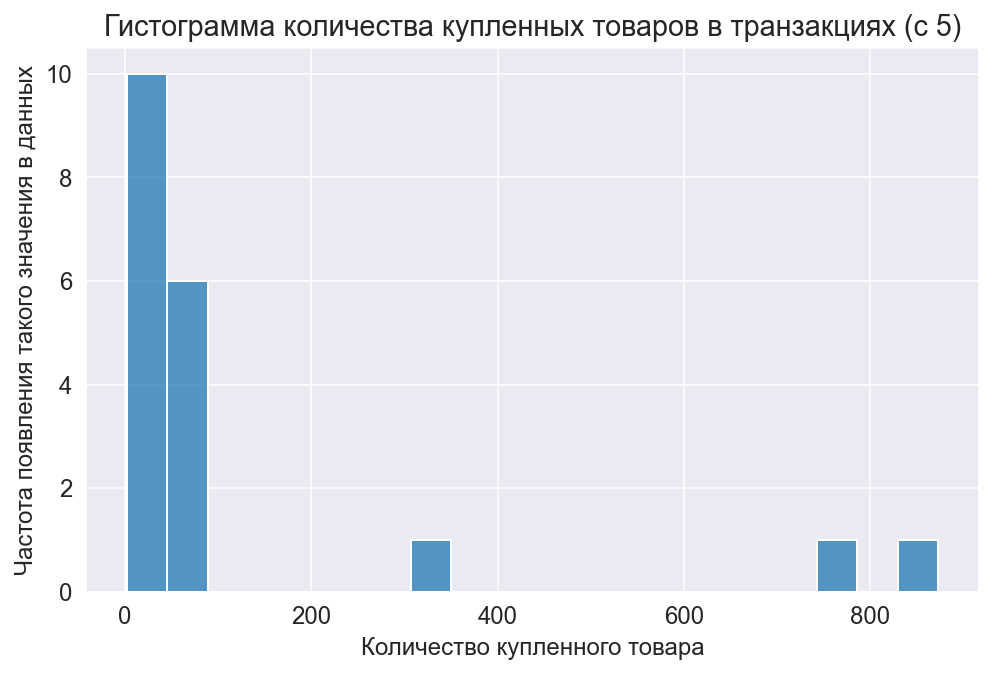

In [493]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

plt.title("Гистограмма количества купленных товаров в транзакциях (с 5)")
plt.xlabel("Количество купленного товара")
plt.ylabel("Частота появления такого значения в данных")

sns.histplot(data=ops, x="Количество")

plt.show()

Гистограмма выглядит очень плохо из-за влияния 5 товара. Посмотрим на распределение остальных товаров.

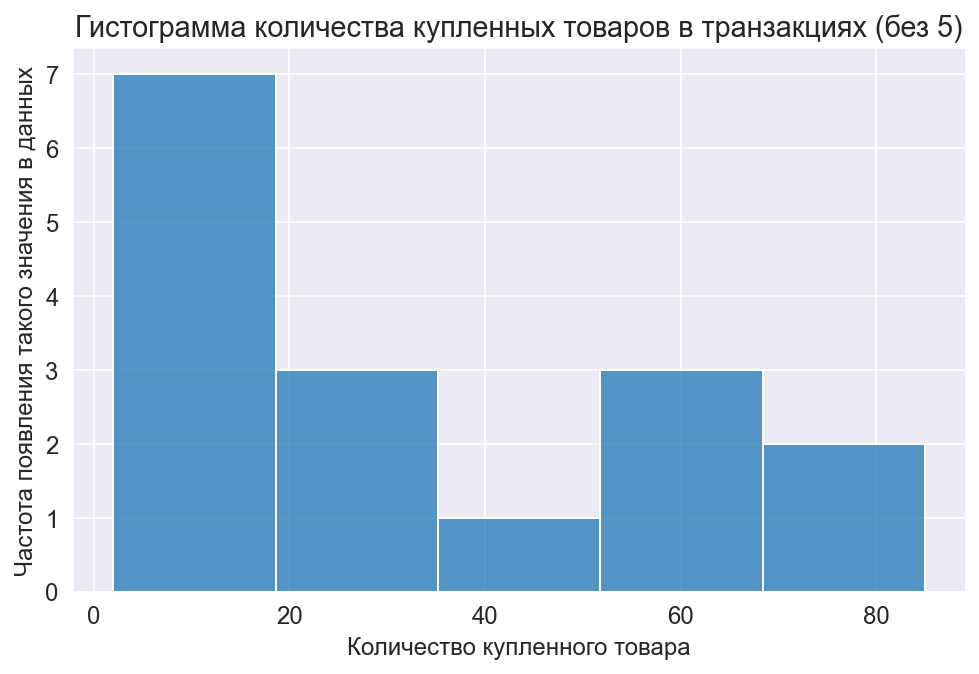

In [499]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

plt.title("Гистограмма количества купленных товаров в транзакциях (без 5)")
plt.xlabel("Количество купленного товара")
plt.ylabel("Частота появления такого значения в данных")

sns.histplot(data=ops_without_5, x="Количество")

plt.show()

Мы видим, что почему-то люди готовы купить 20–35 единиц, 50–70, но не 35–50. Почему? Дело в типе товара? Посмотрим диаграмму "ящик с усами"

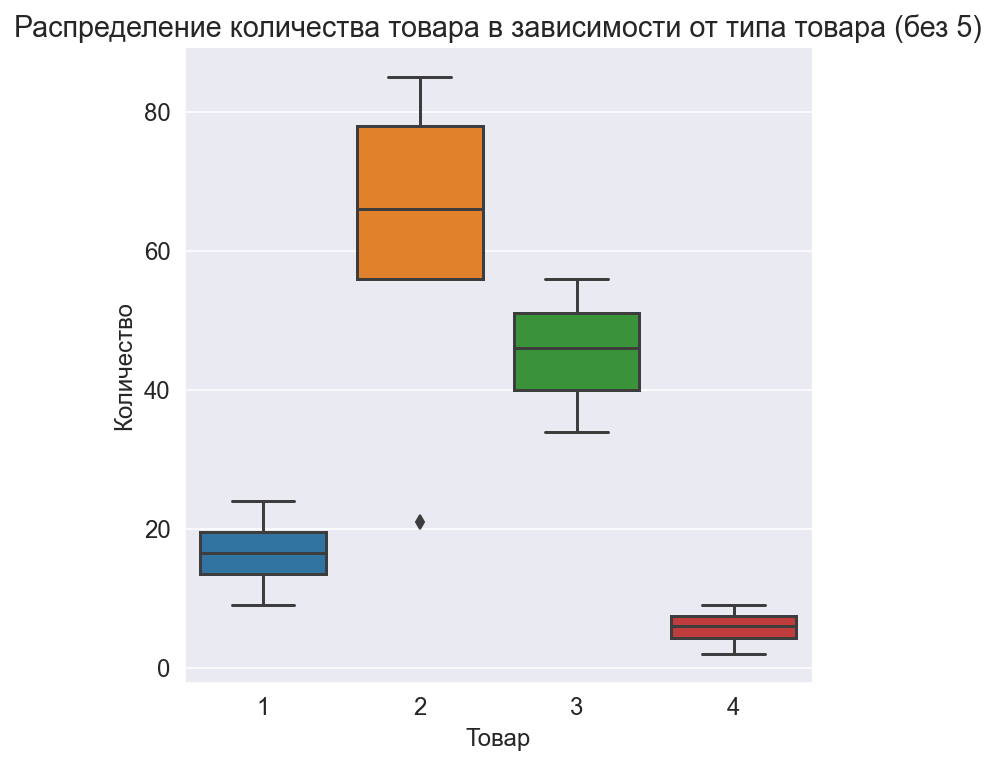

In [507]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Количество", kind="box", data=ops_without_5)

plt.title("Распределение количества товара в зависимости от типа товара (без 5)")
plt.show()

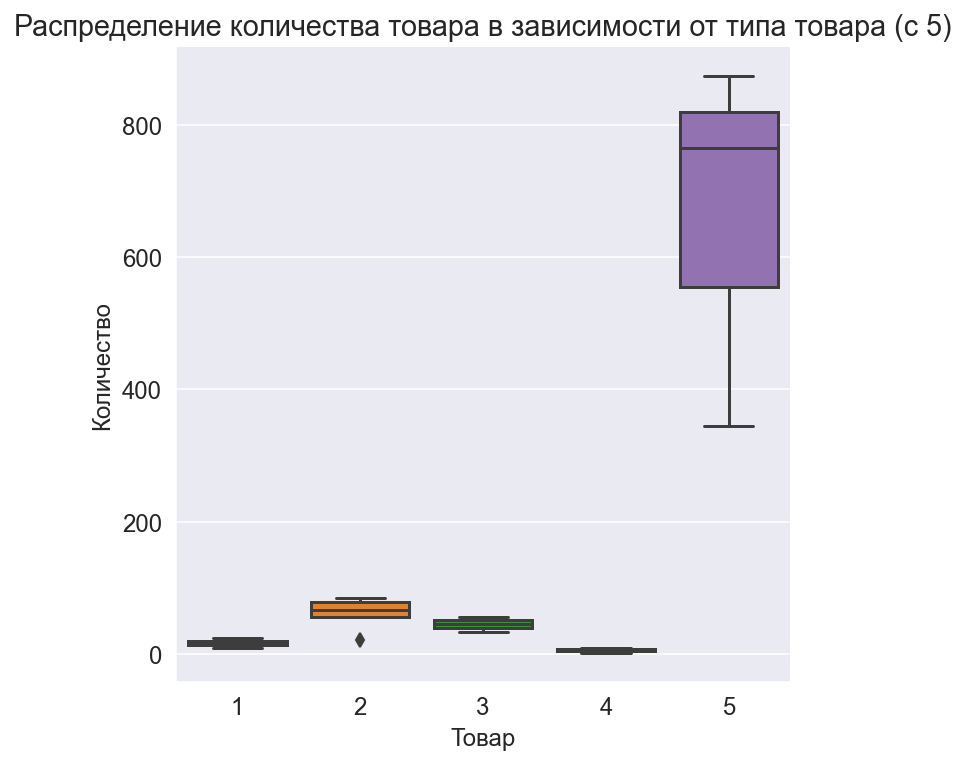

In [506]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Количество", kind="box", data=ops)

plt.title("Распределение количества товара в зависимости от типа товара (с 5)")
plt.show()

Да, действительно, разные товары покупают в разном количестве, притом теперь мы более наглядно видим выводы, которые мы сделали о распределении количества товара, исходя из метрик разброса — 5 действительно в среднем продается очень много, а у остальных среднее количество несильно отклоняется от медианного. Чтобы еще лучше проиллюстрировать доказываемый тезис, построим еще более наглядный график.

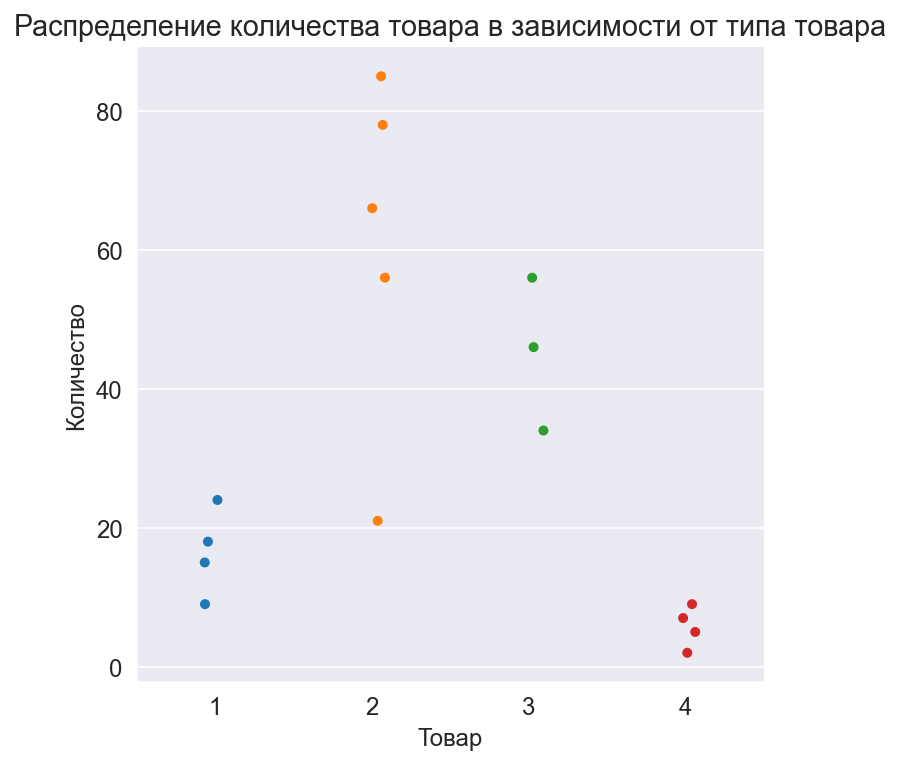

In [475]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Количество", kind="strip", data=ops_without_5)

plt.title("Распределение количества товара в зависимости от типа товара")
plt.show()

Теперь окончательно видна зависимость количества продаваемого товара от типа товара. Таким образом, гистограмма, построенная выше, такая неровная из-за неравномерной популярности товаров, что надо исправлять!

Посмотрим еще на то, как зависит количество от магазина.

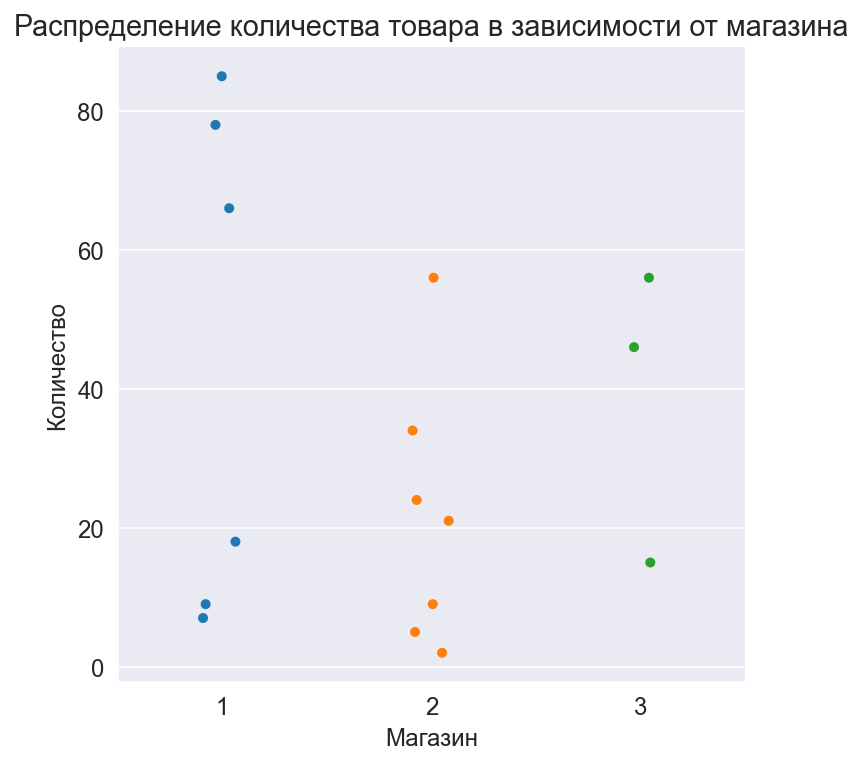

In [478]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Магазин", y="Количество", kind="strip", data=ops_without_5)

plt.title("Распределение количества товара в зависимости от магазина")
plt.show()

Мы видим сильное различие в том, какие количества продаются в разных магазинов, а также в количестве точек для каждого магазина. Чтобы подробнее разобраться, что является причиной, надо проанализировать наши категориальные переменные (id товаров и магазинов).

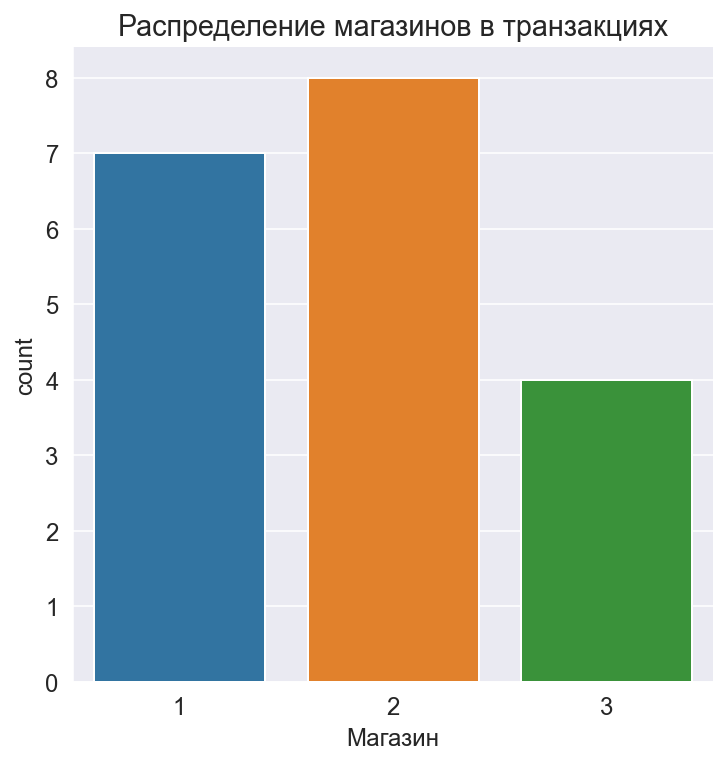

In [485]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Магазин", kind="count", data=ops)

plt.title('Распределение магазинов в транзакциях')
plt.show()

Это снова подтверждает и наглядно демонстрирует выводы, сделанные ранее. С продажами в 3 магазине что-то не так — там продается что-то уникально непопулярное. Посмотрим, какие товары наименее популярны.

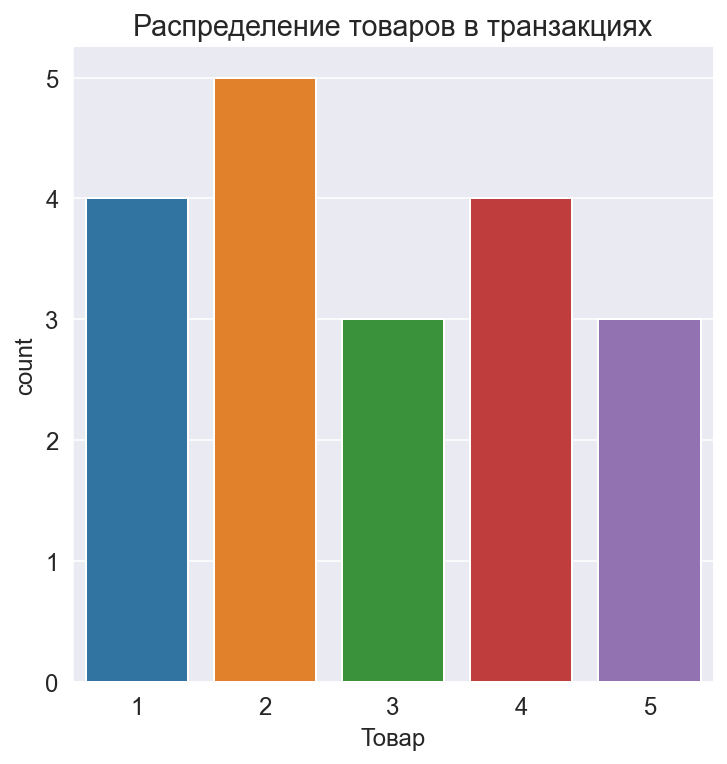

In [486]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", kind="count", data=ops)

plt.title('Распределение товаров в транзакциях')
plt.show()

Действительно, есть чуть более и чуть менее часто покупаемые товары. Возможно, к примеру, в 3 магазине продается мало товаров номер 2 или 4 и много товаров номер 3 (5 давал бы большую прибыль)?

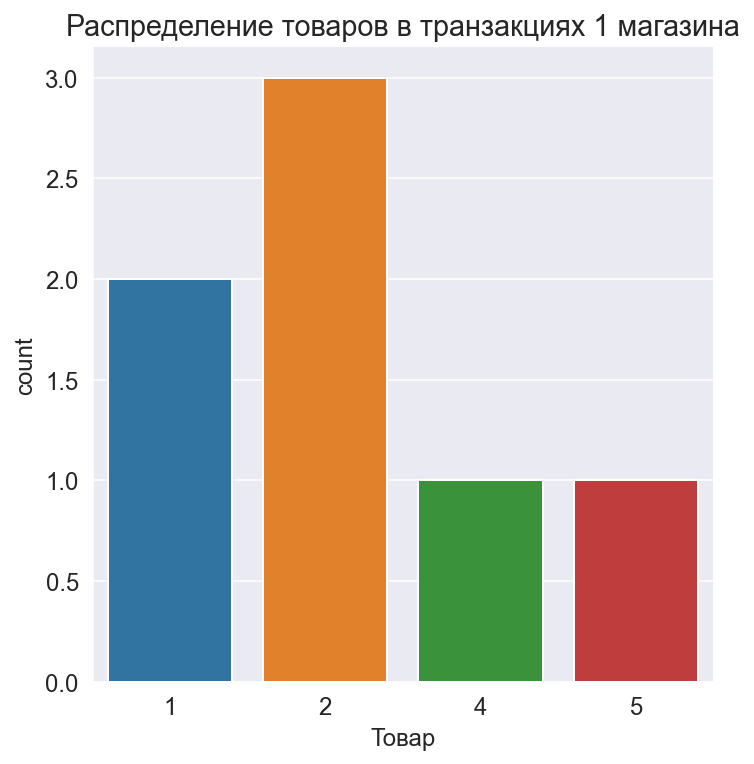

In [487]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", kind="count", data=ops.loc[ops['Магазин'] == 1])

plt.title('Распределение товаров в транзакциях 1 магазина')
plt.show()

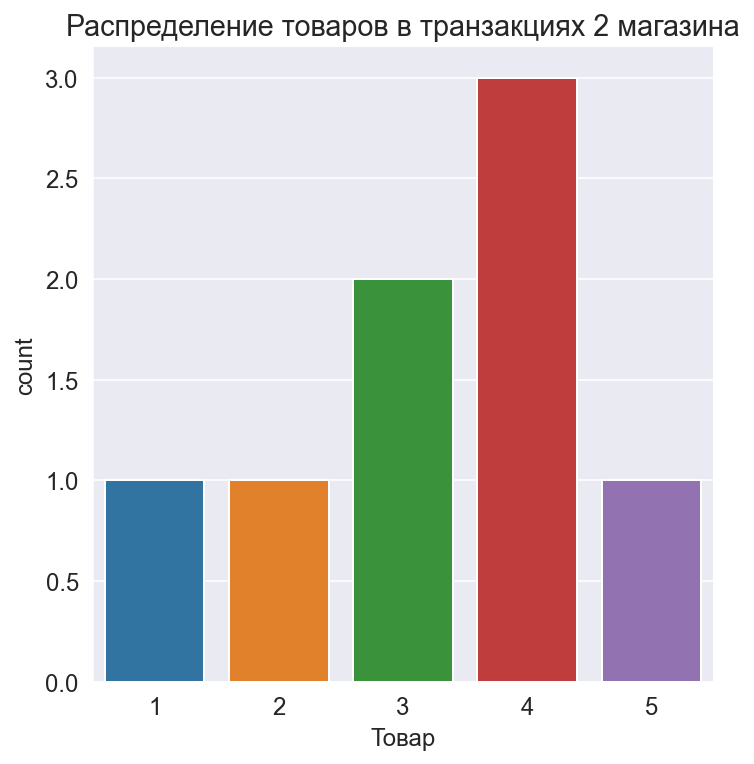

In [488]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", kind="count", data=ops.loc[ops['Магазин'] == 2])

plt.title('Распределение товаров в транзакциях 2 магазина')
plt.show()

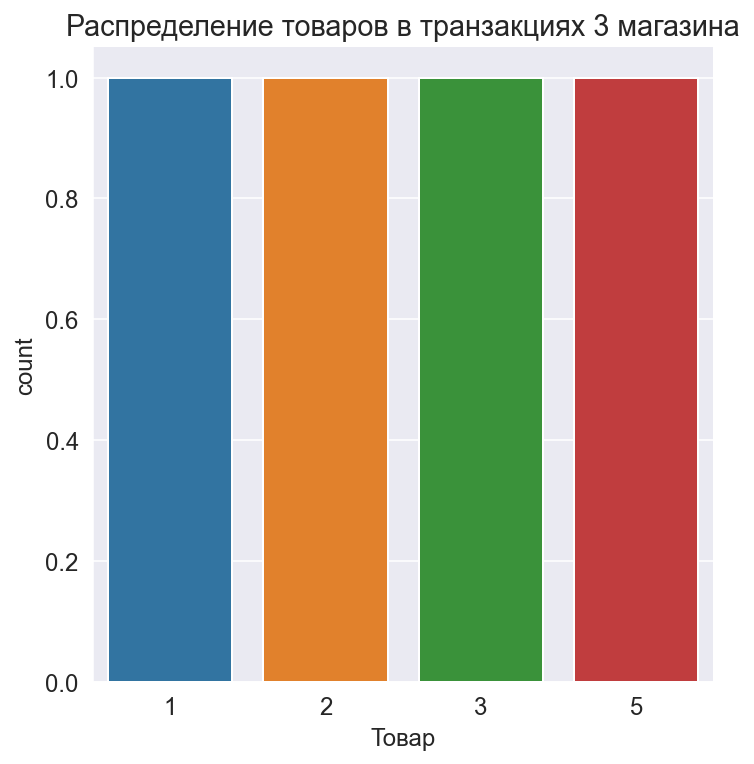

In [489]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", kind="count", data=ops.loc[ops['Магазин'] == 3])

plt.title('Распределение товаров в транзакциях 3 магазина')
plt.show()

Мы видим, что, действительно, в 3 магазине вообще не продается товар номер 4, а остальные товары продаются одинаково. В 3 магазин однозначно стоит добавить 4 товар, а среди остальных товаров начать продавать в большем количестве более прибыльные товары. А чтобы понять, что это за товары, проанализируем оставшийся в таблице `ops` числовой признак — прибыль от транзакции без учета аренды.

Построим его гистограмму.

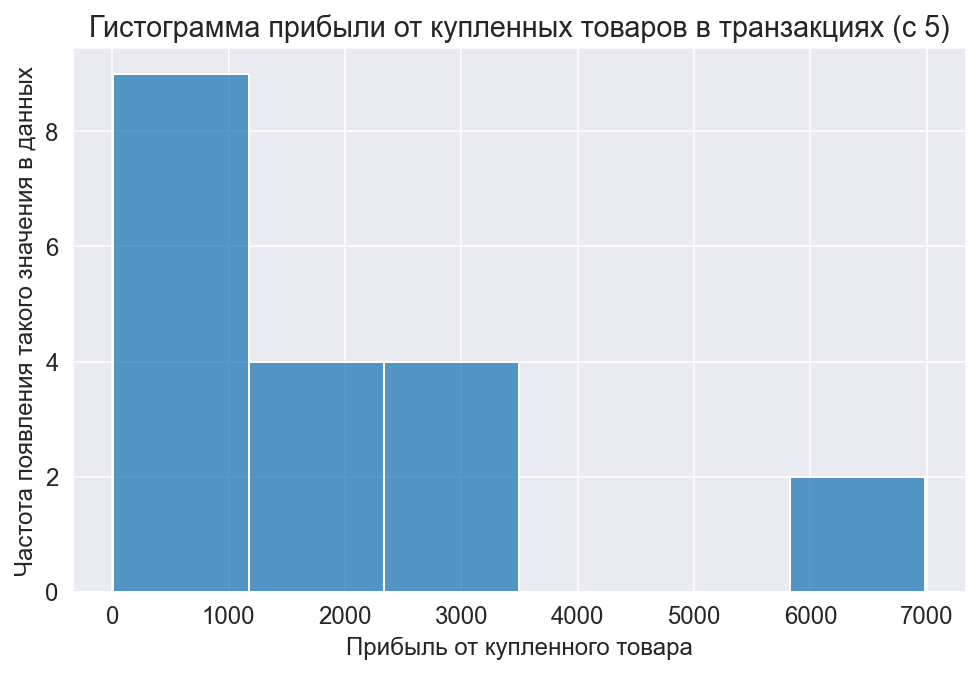

In [498]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

plt.title("Гистограмма прибыли от купленных товаров в транзакциях (с 5)")
plt.xlabel("Прибыль от купленного товара")
plt.ylabel("Частота появления такого значения в данных")

sns.histplot(data=ops, x="Прибыль без учета аренды")

plt.show()

Снова 5 товар все портит и снова исключим его из рассмотрения — и сразу прямоугольник в части 6000–7000 уже не будет ухудшать вид нашей гистограммы.

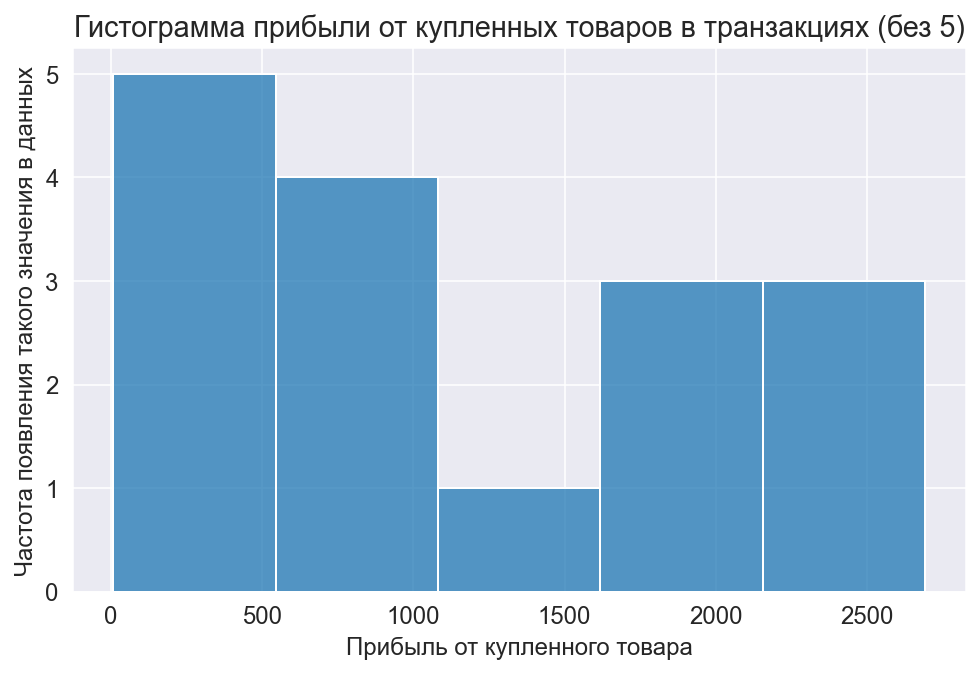

In [500]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

plt.title("Гистограмма прибыли от купленных товаров в транзакциях (без 5)")
plt.xlabel("Прибыль от купленного товара")
plt.ylabel("Частота появления такого значения в данных")

sns.histplot(data=ops_without_5, x="Прибыль без учета аренды")

plt.show()

Мы видим, что чаще всего прибыль или очень высокая, или очень низкая (но, как мы видели, в среднем она в итоге не очень высокая и не очень низкая, если сравнивать с максимальными и минимальными значениями в распределении). Чтобы лучше это объяснить, нарисуем график "ящик с усами" с зависимостью от типа товара.

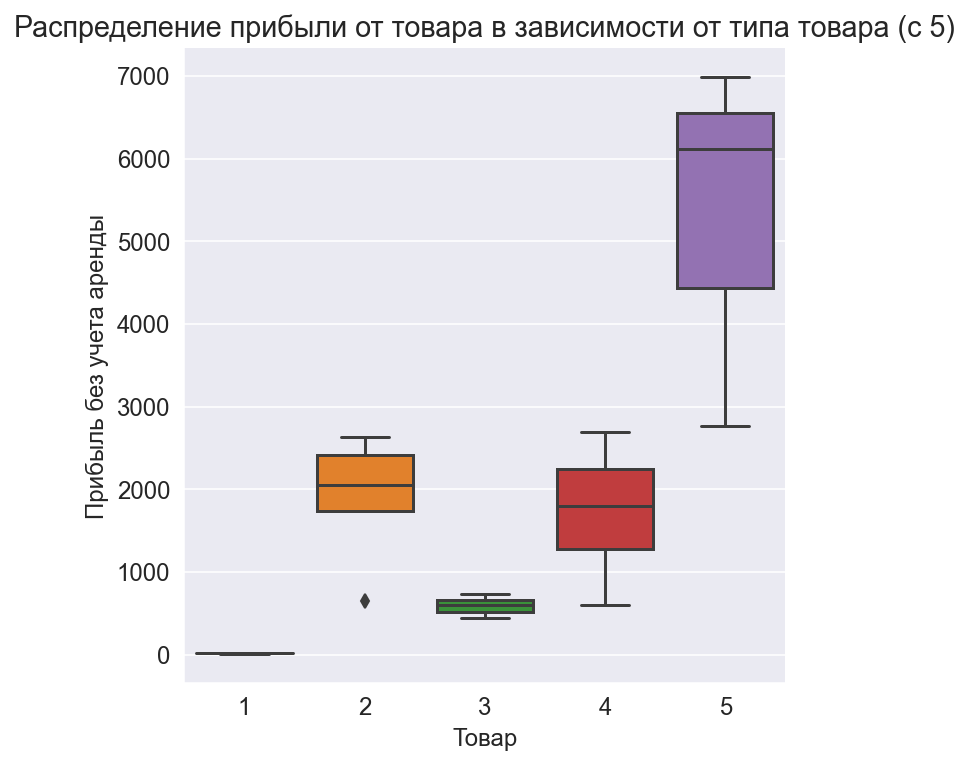

In [504]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="box", data=ops)

plt.title("Распределение прибыли от товара в зависимости от типа товара (с 5)")
plt.show()

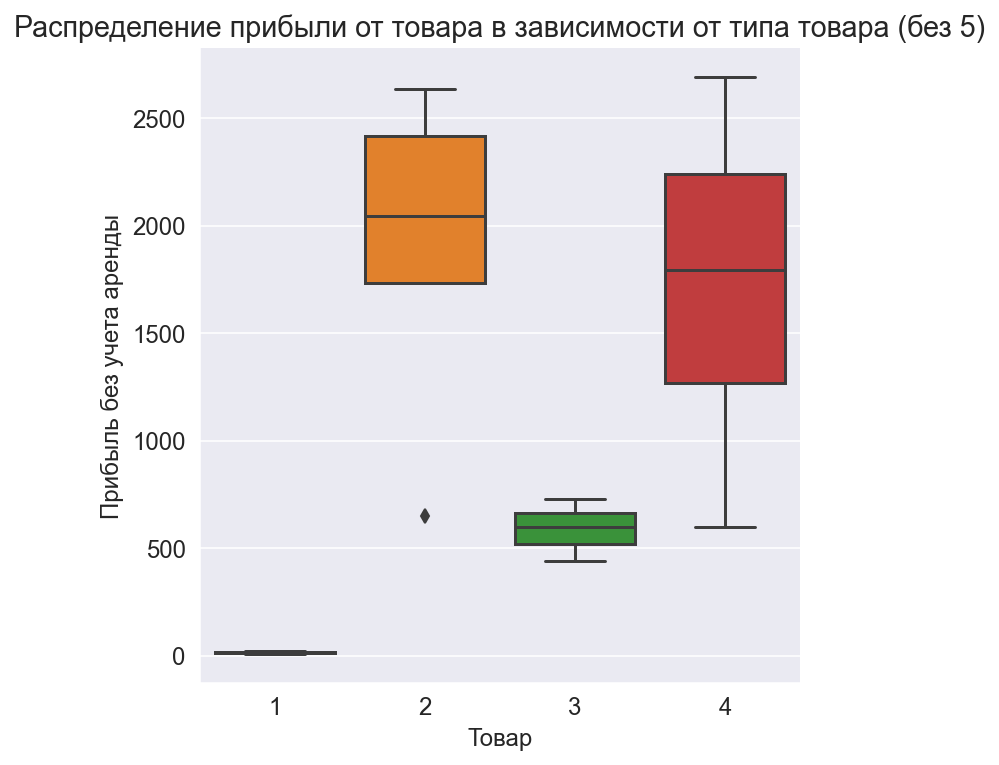

In [505]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="box", data=ops_without_5)

plt.title("Распределение прибыли от товара в зависимости от типа товара (без 5)")
plt.show()

Итак, действительно, есть очень неприбыльные товары, а есть прибыльные, притом у 1–4 среднее не очень отклоняется от медианы, а вот 5 в среднем дает гигантскую прибыль. Если завозить больше товара для увеличения прибыли — то однозначно 2, 4 и 5!

Теперь посмотрим распределение прибыли по магазинам:

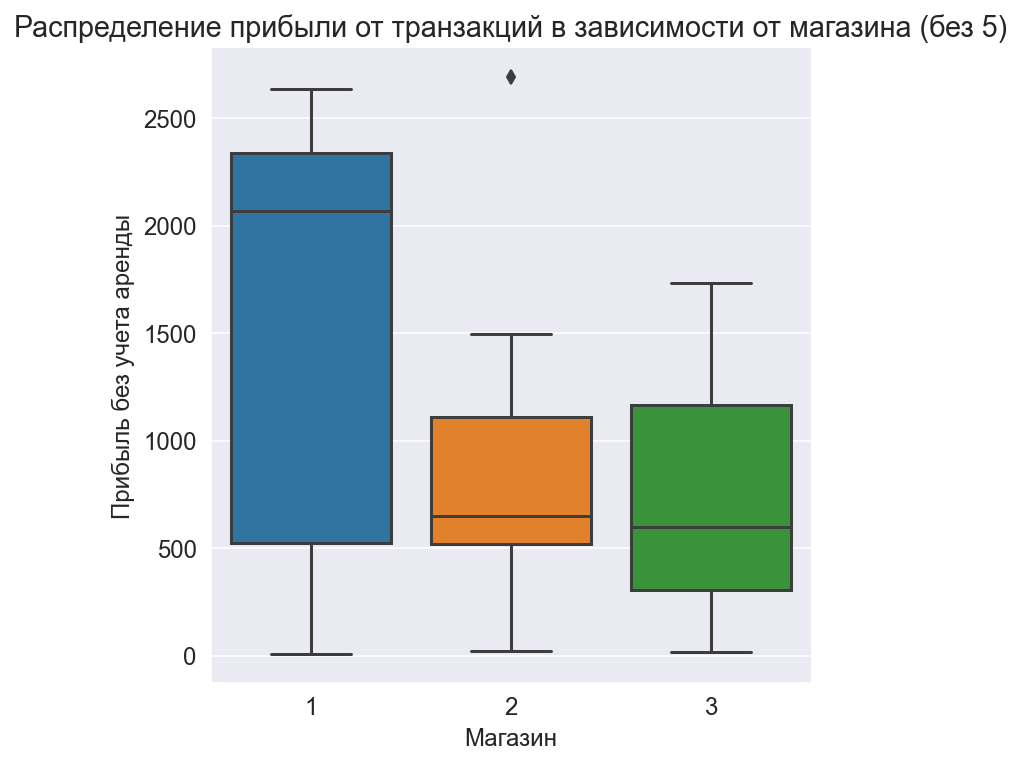

In [510]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Магазин", y="Прибыль без учета аренды", kind="box", data=ops_without_5)

plt.title("Распределение прибыли от транзакций в зависимости от магазина (без 5)")
plt.show()

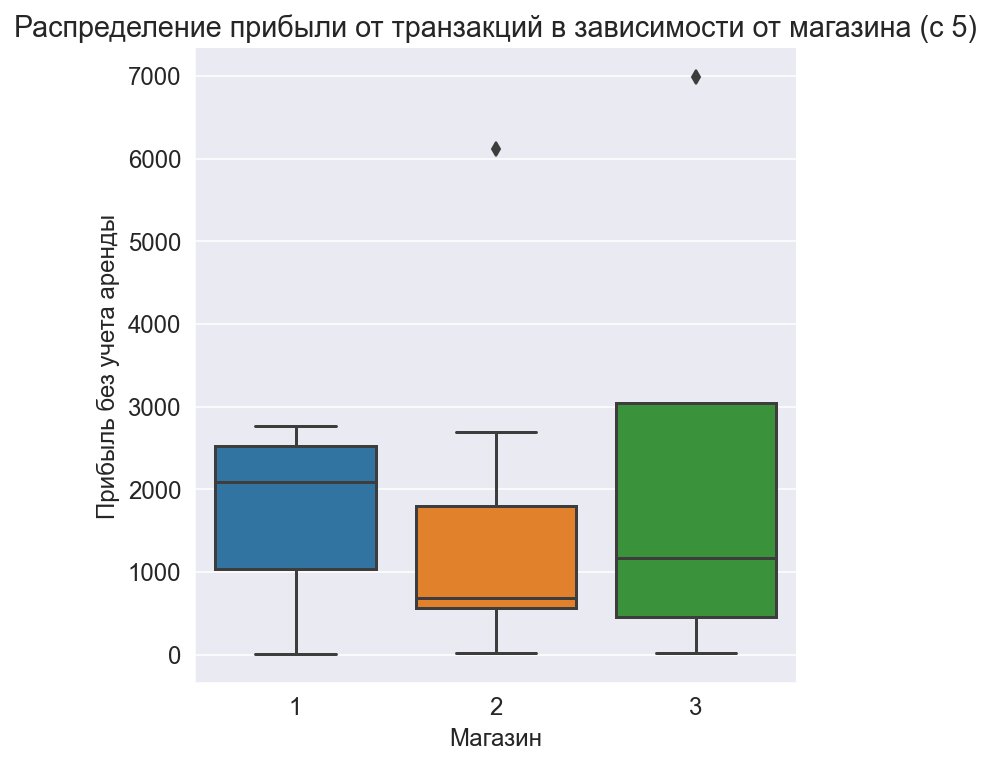

In [511]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Магазин", y="Прибыль без учета аренды", kind="box", data=ops)

plt.title("Распределение прибыли от транзакций в зависимости от магазина (с 5)")
plt.show()

Итак, построенные графики почти окончательно подтверждают тезис: прибыль среди транзакций распределяется приблизительно равномерно, поскольку покупатели в разных магазинах ведут себя примерно одинаково, причина неприбыльности 3 магазина только в том, что в 3 магазине не хватает более прибыльных товаров

Проверим это окончательно, посмотрев, как ведет себя прибыль по товарам 1–4 в каждом отдельном магазине.

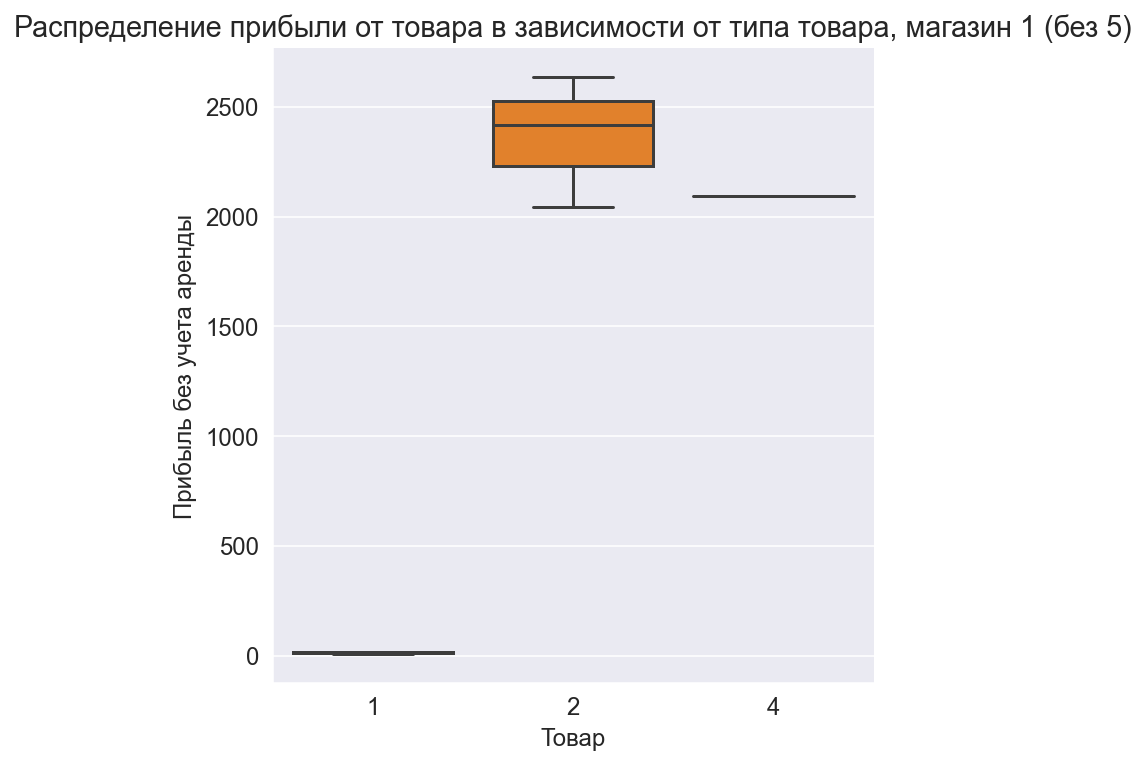

In [512]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="box", data=ops_without_5.loc[ops_without_5['Магазин'] == 1])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 1 (без 5)")
plt.show()

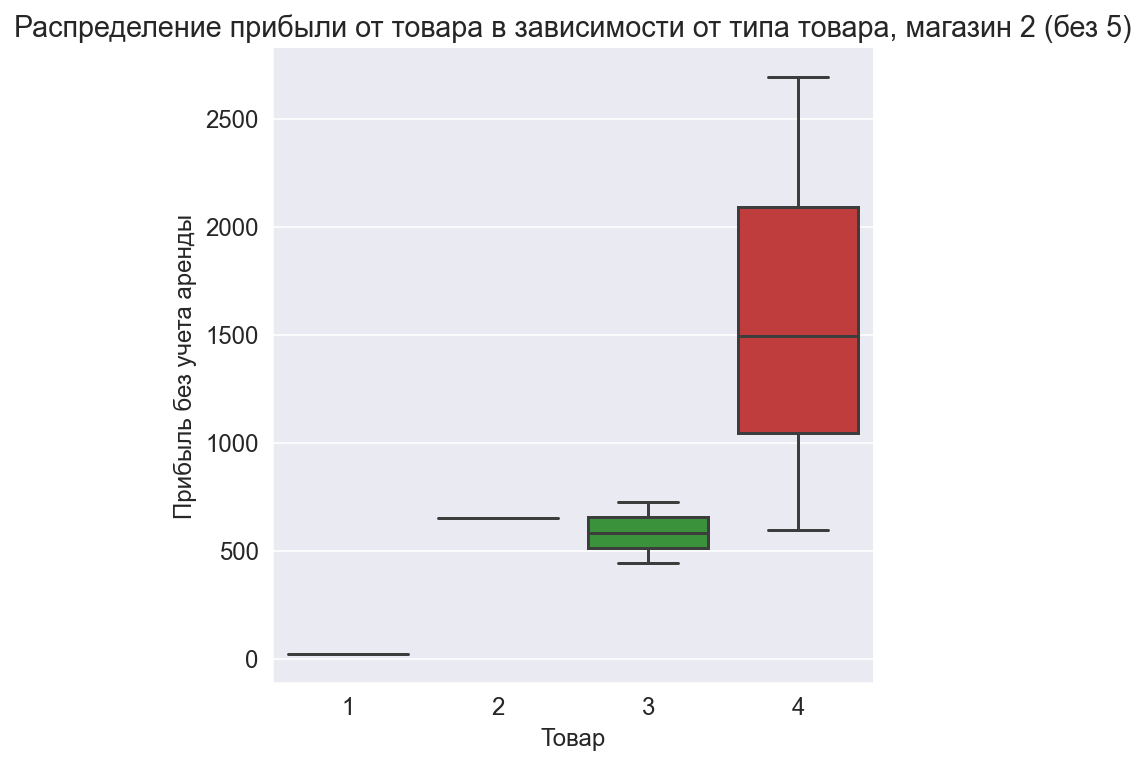

In [513]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="box", data=ops_without_5.loc[ops_without_5['Магазин'] == 2])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 2 (без 5)")
plt.show()

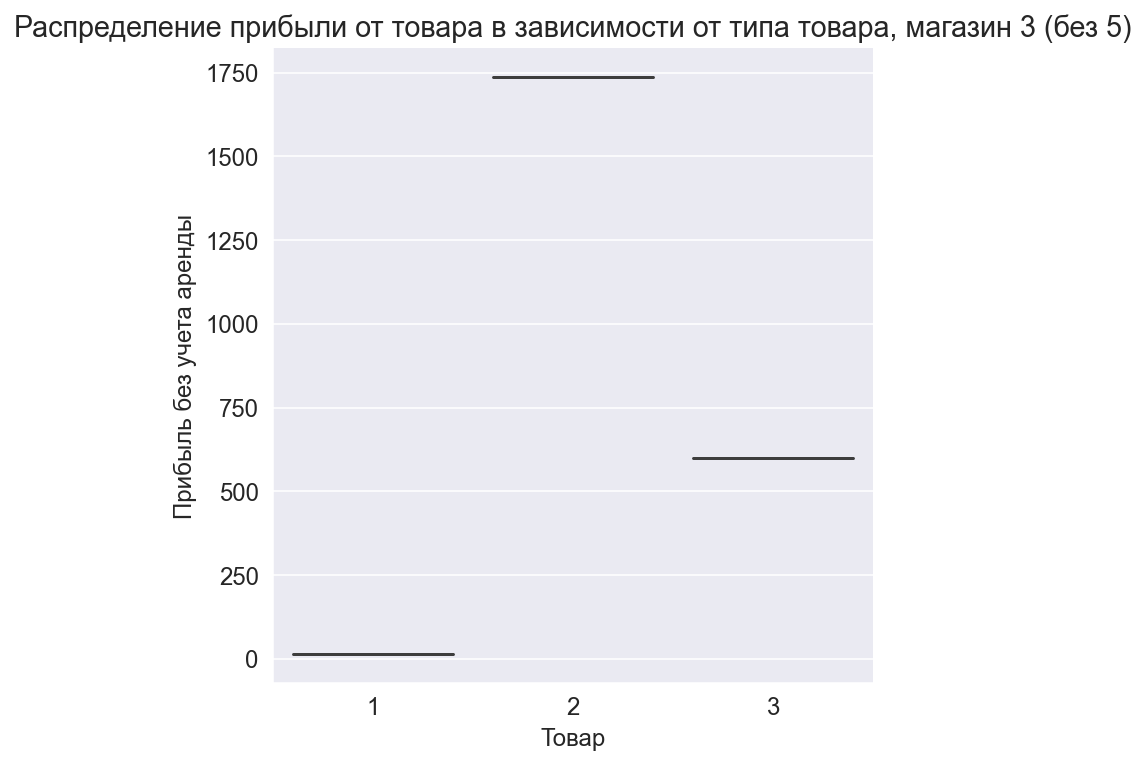

In [514]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="box", data=ops_without_5.loc[ops_without_5['Магазин'] == 3])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 3 (без 5)")
plt.show()

Во-первых, последний график показывает, что 3 магазину остро не хватает прибыльных товаров с типом 1–4. Во-вторых, посмотрим на график "Распределение прибыли от товара в зависимости от типа товара (без 5)", где каждый квадратик характеризует распределение какого-то из 1–4 товаров среди всех магазинов. Теперь в каждом магазине мы видим, что если товар продается в количестве > 1, то там и квадратик будет очень похож. То есть, распределение для всех магазинов сохраняется для отдельного магазина, однако это ничего не доказывает, ведь на трех графиках все квадратики разные — просто разные товары находят свою популярность в разных магазинах. Таким образом, 3 магазин так несправедливо обеделен либо поскольку ни один из товаров 1–3 туда почти не завозится (а 4 вообще не завозится — может, стоит завезти), либо потому что ни один из этих товаров покупателям 3 магазина не нужен. Чтобы понять, в чем именно дело, необходима информация о количестве поставок в каждый магазин, которой мы не располагаем. Однако поэкспериментировать с тем, какой именно товар должен продаваться в 3 магазине, однозначно стоит! При этом 1 товар явно не востребован ни в одном магазине, так что о нем можно даже не думать.

Напоследок, доя большей точности, посмотрим на те же данные с учетом товара 5.

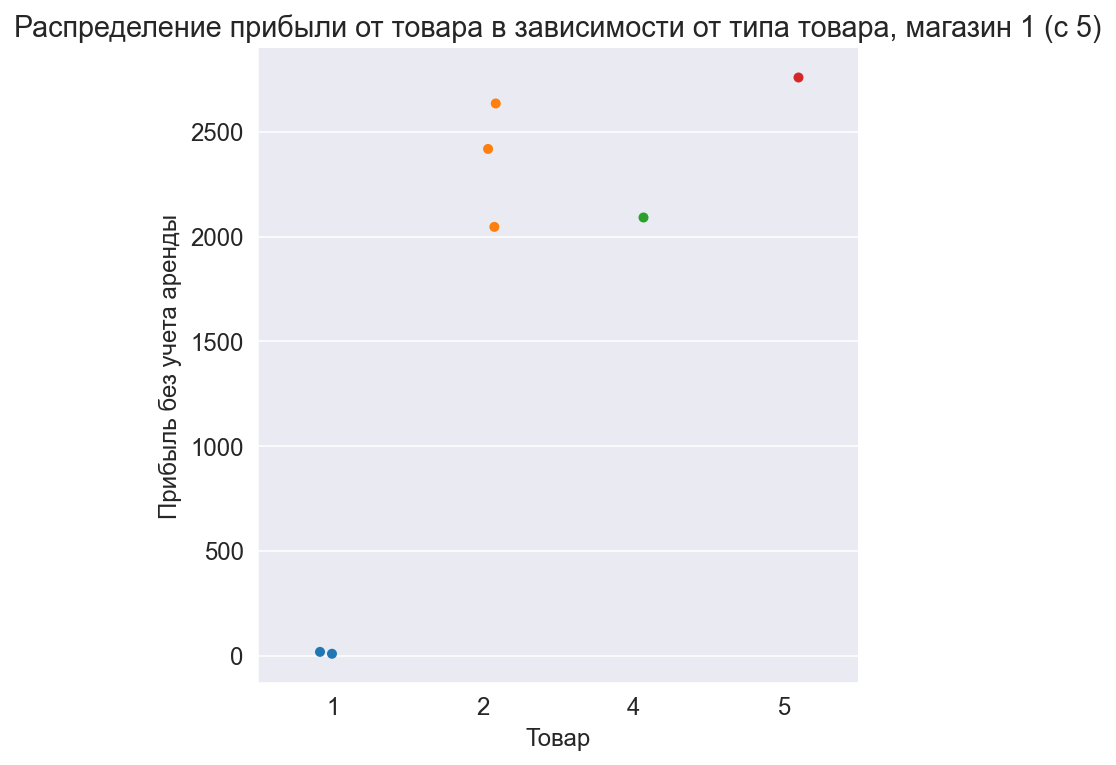

In [605]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="strip", data=ops.loc[ops['Магазин'] == 1])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 1 (с 5)")
plt.show()

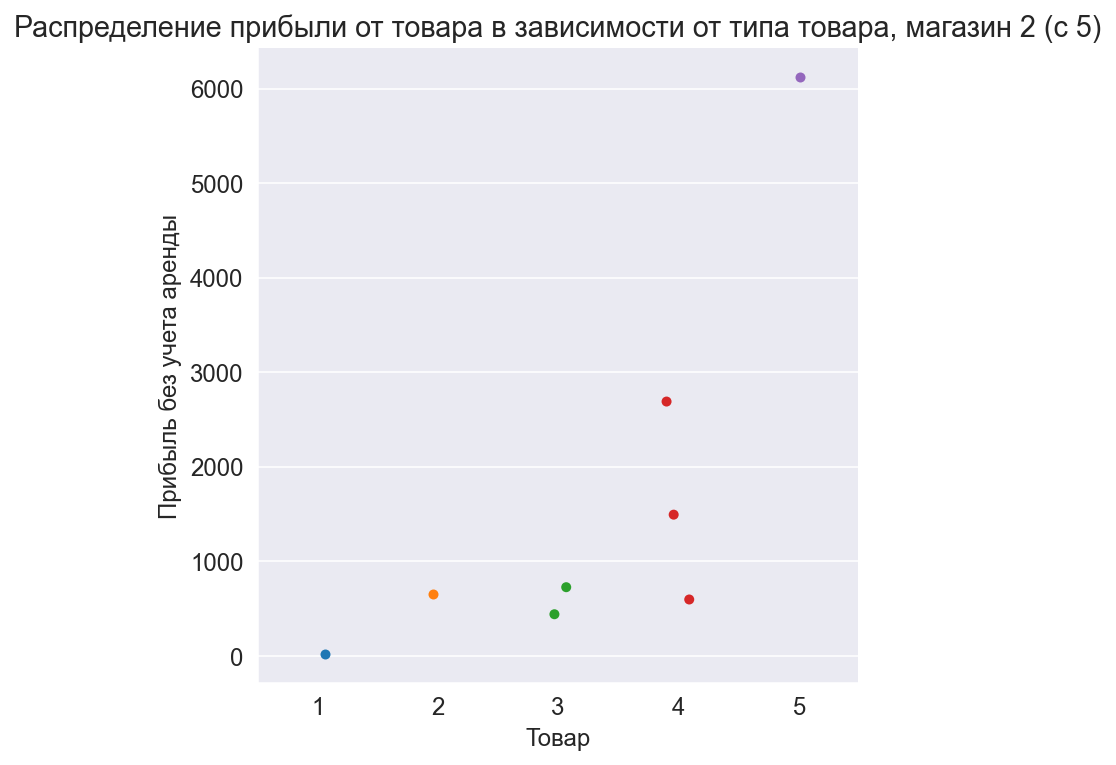

In [606]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="strip", data=ops.loc[ops['Магазин'] == 2])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 2 (с 5)")
plt.show()

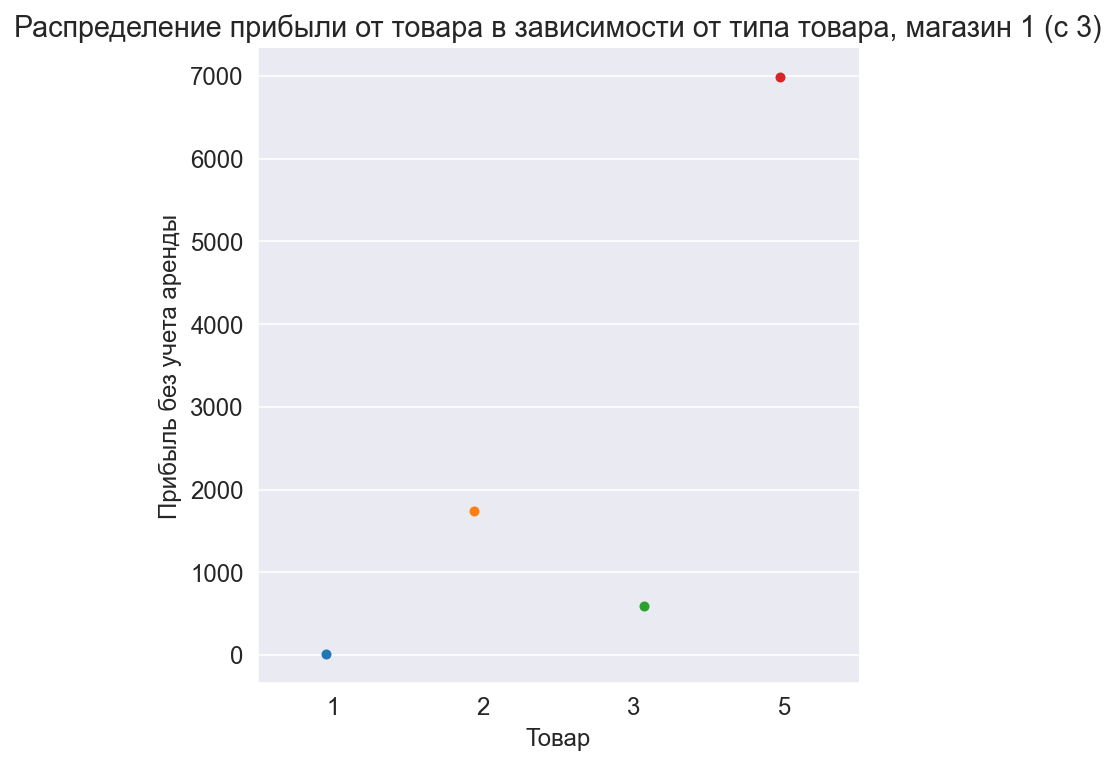

In [607]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"] = 12
sns.set_style("darkgrid")

sns.catplot(x="Товар", y="Прибыль без учета аренды", kind="strip", data=ops.loc[ops['Магазин'] == 3])

plt.title("Распределение прибыли от товара в зависимости от типа товара, магазин 1 (с 3)")
plt.show()

Итак, анализ таблицы с транзакциями завершен. Перечислим основные гипотезы, которые были сделаны по транзакциям:

1. В то время как магазины 1–2 приносят примерно одинаковую прибыль, магазин 3 сильно отстает. Товар 5 везде продается много и прибыльно, так что смотреть стоит на товары 1–4. Товар 1 во всех магазинах приносит мало прибыли. Но у 2 магазина много (после пятого) прибыли приносят товары 3 и 4, у 1 магазина — товар 2, а 3 магазина такого товара нет — 2 и 3 прибыли почти не приносят в сравнении с другими магазинами (и товары 1, 2 и 3 продаются в одинаковых количествах), а 4 товар вообще не продается. Также в 1 магазине не продается 3 товар. Итак, для 1 и 3 магазина есть возможность попробовать учеличить прибыль, ведь там продаются еще не все возможные товары.

2. Средняя транзакция дает не очень высокую и не очень низкую прибыль, но чаще всего встречаются транзакции с очень высокой или очень низкой прибылью — стоило бы уменьшить долю транзакций с маленькой прибылью и увеличить долю со средней с помощью более эффективного управления в первую очередь 3 магазином, который и дает большое количество неприбыльных транзакций — транзакции достаточно часто совершаются в 3 магазине, и он же самый неприбыльный, отсюда и такое количество транзакций с низкой прибылью.

3. Товары разных типов продаются разными количествами — к примеру, 5 товар всегда покупают очень много, а 1 товар всегда очень мало. И у разных товаров количества, с которыми они были проданы в разных транзакциях, всегда будут различаться. Однако при этом разные в разных магазинах в большом количестве покупают разные товары. Поэтому это не говорит однозначно о том, что количество, в котором покупают различные товары, это свойство самих товаров — возможно, это свойство людей, живущих в местах, в которых расположены разные магазины. Но что можно утверждать однозначно — есть прибыльные, а есть неприбыльные товары. Ни в одном магазине продажи 1 товара не принесли заметную прибыль. А вот 5, к примеру, везде дает гигантскую прибыль! Так что прибыль можно увеличить, если в магазин завезти больше товаров 2, 4 и 5.

Из условия следует, что выборка по транзакциям репрезентативна, поэтому эти выводы можно было делать таким образом, каким они были сделаны в данной работе.

Из остальных таблиц вряд ли можно сделать какие-то серьезные выводы, так что анализировать их не будем — они содержат скорее справочную информацию.

#### Интерпретация данных

Итак, в работе были сформулированы некоторые гипотезы, исходя из анализа данных. Какие можно принять решения? Перед тем, как перечислить возможные решения, стоит отметить, что лучше всего принимать только одно решение за раз, чтобы было проще проводить А/В-тест.

1. Попробовать провести рекламу 1 товара, чтобы увеличить его продажи. Судя по тому, что за 1 день нескольким покупателям удалось зайти сразу в несколько магазинов, расположены они как минимум в одном городе, поэтому реклама поможет продажам 1 товара сразу в 3 магазинах. 

2. Завезти 4 товар в 1 магазин и посмотреть, как он продается.

3. Завезти 2 или 4 товар в 3 магазин, чтобы в нем стало больше действительно прибыльных транзакций, или провести маркетинговое исследование, чтобы понять, какой еще можно туда завезти товар, и завезти какой-то 6 товар.

4. Мы видим, что есть покупатели, которые могут заходить в магазин несколько раз за день. Стоит выпустить для них карту лояльности.

5. Поскольку ни один товар не приносит убытков, продажи ни одного товара точно не стоит сокращать — продажи надо стараться только увеличивать.

6. Заниматься нужно товарами 1–4 — товар 5 и так отлично продается, так что его ни рекламировать, ни завозить куда-либо не нужно, а внимание требуется уделить в первую очередь 3 магазину.